In [26]:
# open file list_attr_celeba.txt and read the content in a list

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_path = "data/img_align_celeba"
df = pd.read_csv("data/list_attr_celeba.csv")
# df = df.head(10000)
df = df.tail(10000)
print(df.columns)


feature_filter = {"glasses":[(df['Eyeglasses'] == 1) & (df['Male']==1), (df['Eyeglasses'] == -1) & (df['Male']==1)],
                   "beard":[(df['No_Beard'] == -1) & (df['Male'] == 1), (df['No_Beard'] == 1) & (df['Male'] == 1)]}

current_feature = "beard"

with_glasses = df['image_id'][feature_filter[current_feature][0]].tolist()
without_glasses = df['image_id'][feature_filter[current_feature][1]].tolist()

print(len(with_glasses))
print(len(without_glasses))

print(with_glasses[-5])




Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
1453
2393
202561.jpg


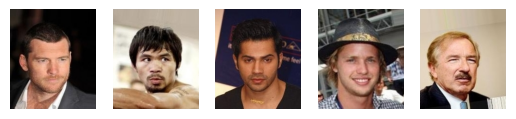

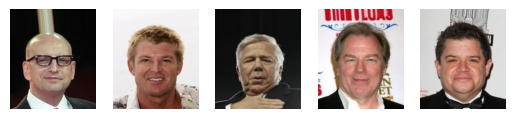

In [27]:
glass_images = [Image.open(f'{img_path}/{with_glasses[np.random.randint(0, len(with_glasses))]}') for i in range(5)]
f = plt.figure()
for i in range(5):
    # Debug, plot figure
    f.add_subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(glass_images[i])

plt.show(block=True) 

no_glass_images = [Image.open(f'{img_path}/{without_glasses[np.random.randint(0, len(without_glasses))]}') for i in range(5)]
f = plt.figure()
for i in range(5):
    # Debug, plot figure
    f.add_subplot(1, 5, i + 1)
    plt.axis('off')
    plt.imshow(no_glass_images[i])

plt.show(block=True) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


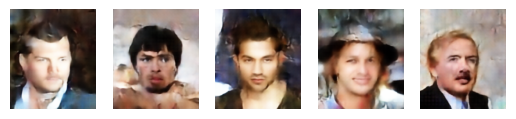

In [28]:
from VanillaVAE import VanillaVAE
import torch
from torchvision import transforms


INPUT_DIM = 3

Z_DIM = 500
PATH = "bestmodel_wandb3_newer.pt"
device = torch.device('cpu')

model = VanillaVAE(INPUT_DIM, Z_DIM)
checkpoint = torch.load(PATH,map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

transform=transforms.ToTensor()

f = plt.figure()
for i in range(len(glass_images)):
    with torch.no_grad():
        out = model.forward(transform(glass_images[i]).unsqueeze(0).to(device))[0]
        
    out = out.view(-1, 3, 224, 192)
    out = np.transpose(out, (0, 2, 3, 1))
    f.add_subplot(1, len(glass_images), i + 1)
    plt.axis('off')
    plt.imshow(out[0])



In [29]:
delta_mu = torch.load('delta_mu.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


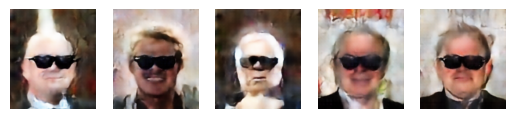

In [39]:
import matplotlib.pyplot as plt
from PIL import ImageFilter
import torchvision

coef = 2.2

f = plt.figure()
for i in range(len(no_glass_images)):
    with torch.no_grad():
        x = transform(no_glass_images[i]).unsqueeze(0).to(device)
        # x = torch.rand_like(transform(no_glass_images[i]).unsqueeze(0)).to(device) 
        # x = torch.zeros_like(x).to(device)
        out = model.generate_with_delta(x,delta_mu*coef,without_variance=False) #torch.zeros_like(delta_mu))
        
    out = out.view(-1, 3, 224, 192)
    #img = torchvision.transforms.functional.to_pil_image(out[0], mode=None)
    out = np.transpose(out, (0, 2, 3, 1))

    # img = img.filter(ImageFilter.SHARPEN)
    
    f.add_subplot(1, len(no_glass_images), i + 1)
    plt.axis('off')
    plt.imshow(out[0])